## Generate real data examples (previously figure 4), for the sensitivity analysis manuscript 
We apply the hessian-based sensitivity analysis method to examples of real wearable data. Using rescaled activity in place of light, we generate hessian matrices for real individuals and examine their overall sensitivity and individual parameter sensitivity. 

This figure conists of two main components. First, we compute the principal eigenvector of the hessian matrices and plot these for the three subjects of interest. Next, we compute a heatmap figure where we compare the prinicipal eigenvector of the real data examples with those from the six synthetic light schedules. 

In [8]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, jacfwd, jacrev
import jax.numpy as jnp
import pandas as pd 
import os 
import csv
import seaborn as sns

# import the needed modules 
from hessian_normalized import HessianCircadian

sens=HessianCircadian()
params = sens.get_parameters_array()

figure_save == 'off'

# function for generating initial conditions 
def ics_individual_schedules(final_state_diff, convergence_val, ics, lights, params):
    u0 = ics
    count = 0
    while final_state_diff > convergence_val and count < 50:

        # simulate the model and extract the final time as the initial condition
        count = count + 1
        statesfinal = sens.step_n(u0 = u0, light = lights, params = params, dt = 0.10) # final state value
        final_state_diff = abs(statesfinal[0] - u0[0]) + abs(np.mod(statesfinal[1] - u0[1] + np.pi,2*np.pi) - np.pi)
        #print(final_state_diff)
        u0 = statesfinal
    return u0

# generate the initial conditions for the individual schedules 
convergence_val = 10**(-3)
final_state_diff = 100

Next we read in the real data and run the activity schedules in order to generate individual hessian matrices. Note that to do this we generate new initial conditions for each of the individuals, and we use rescaled activity in place of light. 

Change the parameters at the beginning of this cell to look at additional data examples, numbers of days, etc. 

In [9]:
# filepath where real data is stored 
filepath = "/Users/calebmayer/Documents/MATLAB/Examples/matlab/ArrayIndexingGSExample/covid/data_s"

# define parameters 
count = 0
num_subjects = 10
start_pt = 1
num_days = 7
convergence_val = 10**(-3)
final_state_diff = 100
ics = jnp.array([0.70,0.0,0.0])
activity_scaling_factor = 1
dt = 0.1

# initialize record/list of hessian matrices 
hessianVal_rl = []

# iterate through the selected files 
for j in range(start_pt, start_pt + num_subjects):
    
    filename = os.listdir(filepath)[j] # num_subjects files for now--take the steps ones 
    print(j)
    
    if 'steps' in filename:

        data = pd.read_csv(filepath + '/' + filename)
        data_np = pd.DataFrame.to_numpy(data)
        
        # convert time to hours 
        data_np[:,0] = data_np[:,0] - data_np[0,0]
        data_np[:,0] = data_np[:,0]*24

        ts = data_np[:,0]
        lights = data_np[:,1]
        lights = lights[ts < num_days*24]
        ts = ts[ts < num_days*24]
        
        # resample the data 
        ts_new = np.arange(ts[0], ts[-1], dt)
        lights_new = np.zeros([len(ts_new)])
        
        for m in range(len(ts_new)-1):
            
            index1 = ts > ts_new[m]
            index2 = ts <= ts_new[m+1]
            index = np.logical_and(index1,index2) 
            light_vals = lights[index]
            lights_new[m] = np.sum(light_vals)*activity_scaling_factor # adjust this as needed
            
        # generate new initial conditions for each individual 
        ics_looped = ics_individual_schedules(final_state_diff, convergence_val, ics, lights_new, params)
        
        # apply the hessian method to the rescaled activity data and new ics 
        hessianVal_rl.append(sens.normalized_hessian(u0 = ics_looped, light=lights_new)) # use ending value as new initial condition 
        count = count+1

1
2
3
4
5
6
7
8
9
10


## Generate bar plots of the principal eigenvectors
Here we compute the principal eigenvectors of the hessian matrix for selected example subjects, and plot the results. 

Overall sensitivity of the example individuals are given by
340.01947
293.45334
504.47314


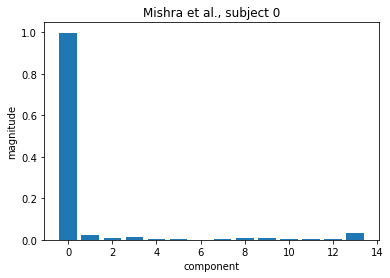

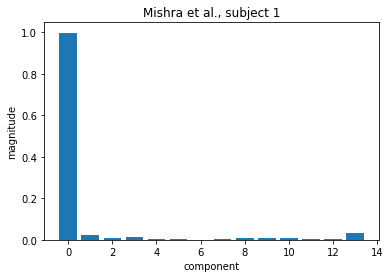

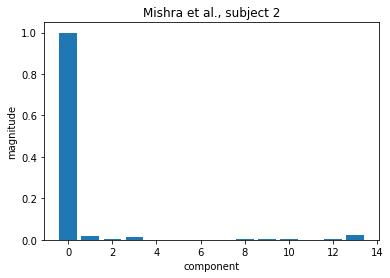

In [10]:
# choose the example subjects 
ind1 = 0
ind2 = 1
ind3 = 2

# compute the frobenius norm of the hessian, as an overall sensitivity metric 
print('Overall sensitivity of the example individuals are given by')
print(np.linalg.norm(hessianVal_rl[ind1]))
print(np.linalg.norm(hessianVal_rl[ind2]))
print(np.linalg.norm(hessianVal_rl[ind3]))

# find the principal eigenvector for the three example individuals 
evals, evecs = np.linalg.eig(hessianVal_rl[ind1])
evec1 = abs(evecs[:,np.argmax(evals)])
plt.bar(range(len(evecs)),abs(evecs[:,np.argmax(evals)]))
plt.title('Mishra et al., subject %i' % ind1)
plt.ylabel('magnitude')
plt.xlabel('component')
if figure_save == 'on':
    plt.savefig('figures_8_29/real_data_ex0.svg')
plt.show()

evals, evecs = np.linalg.eig(hessianVal_rl[ind2])
evec2 = abs(evecs[:,np.argmax(evals)])
plt.bar(range(len(evecs)),abs(evecs[:,np.argmax(evals)]))
plt.title('Mishra et al., subject %i' % ind2)
plt.ylabel('magnitude')
plt.xlabel('component')
if figure_save == 'on':
    plt.savefig('figures_8_29/real_data_ex1.svg')
plt.show()

evals, evecs = np.linalg.eig(hessianVal_rl[ind3])
evec3 = abs(evecs[:,np.argmax(evals)])
plt.bar(range(len(evecs)),abs(evecs[:,np.argmax(evals)]))
plt.title('Mishra et al., subject %i' % ind3)
plt.ylabel('magnitude')
plt.xlabel('component')
if figure_save == 'on':
    plt.savefig('figures_8_29/real_data_ex2.svg')
plt.show()


We print the Frobenius norm of the hessian (overall sensitivity) metrics for the example schedules, and then plot the principal eigenvector for the selected examples. As with the synthetic light schedules previously studied, we observe that the first component of the prinicipal eigenvector is much larger in magnitude than the rest. 

## Generate heatmap eigenvector comparison figure 
Here we compare the principal eigenvectors of the six synthetic schedules with those from the example schedules via a normalized dot product, and display the results in a heatmap.  

[Text(0, 0.5, 'Ex. 1'), Text(0, 1.5, 'Ex. 2'), Text(0, 2.5, 'Ex. 3')]

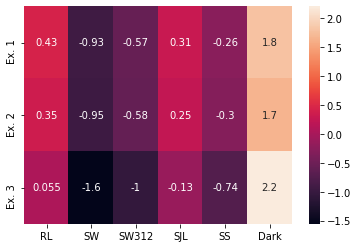

In [11]:
# read in the stored eigenvalues, from clean_figure2.ipynb
%store -r evecs_rl
%store -r evecs_sw
%store -r evecs_sw312
%store -r evecs_sjl
%store -r evecs_ss
%store -r evecs_dark

num_schedules = 6
num_examples = 3

# compute the dot product between principal eigenvectors of real and synthetic schedules 
dot_mat_subject_all = np.zeros([num_examples,num_schedules])
dot_mat_subject_all[0,0] = np.dot(np.abs(evec1),np.abs(evecs_rl))
dot_mat_subject_all[0,1] = np.dot(np.abs(evec1),np.abs(evecs_sw))
dot_mat_subject_all[0,2] = np.dot(np.abs(evec1),np.abs(evecs_sw312))
dot_mat_subject_all[0,3] = np.dot(np.abs(evec1),np.abs(evecs_sjl))
dot_mat_subject_all[0,4] = np.dot(np.abs(evec1),np.abs(evecs_ss))
dot_mat_subject_all[0,5] = np.dot(np.abs(evec1),np.abs(evecs_dark))

dot_mat_subject_all[1,0] = np.dot(np.abs(evec2),np.abs(evecs_rl))
dot_mat_subject_all[1,1] = np.dot(np.abs(evec2),np.abs(evecs_sw))
dot_mat_subject_all[1,2] = np.dot(np.abs(evec2),np.abs(evecs_sw312))
dot_mat_subject_all[1,3] = np.dot(np.abs(evec2),np.abs(evecs_sjl))
dot_mat_subject_all[1,4] = np.dot(np.abs(evec2),np.abs(evecs_ss))
dot_mat_subject_all[1,5] = np.dot(np.abs(evec2),np.abs(evecs_dark))

dot_mat_subject_all[2,0] = np.dot(np.abs(evec3),np.abs(evecs_rl))
dot_mat_subject_all[2,1] = np.dot(np.abs(evec3),np.abs(evecs_sw))
dot_mat_subject_all[2,2] = np.dot(np.abs(evec3),np.abs(evecs_sw312))
dot_mat_subject_all[2,3] = np.dot(np.abs(evec3),np.abs(evecs_sjl))
dot_mat_subject_all[2,4] = np.dot(np.abs(evec3),np.abs(evecs_ss))
dot_mat_subject_all[2,5] = np.dot(np.abs(evec3),np.abs(evecs_dark))

# generate the normalized heatmap figure 
dot_mat_subject_all_norm = (dot_mat_subject_all - np.mean(dot_mat_subject_all))/np.std(dot_mat_subject_all)
ax = sns.heatmap(dot_mat_subject_all_norm, annot = True)
ax.set_xticklabels(['RL','SW','SW312','SJL','SS','Dark'])
ax.set_yticklabels(['Ex. 1', 'Ex. 2', 'Ex. 3'])
if figure_save == 'on':
    plt.savefig('figures_8_29/real_data_heatmap_normalized.svg')

The heatmap figure above should give similarity measurements between the principal eigenvectors of the synthetic light schedules and the real light schedule examples. We see high similarity with the regular light schedule (for 2/3 examples at least), the social jet lag schedule, and the constant darkness schedule. Lower similarities occur for the two shift work schedules. 

Note that this result will depend to some degree on the activity scaling factor we use, to convert the activity data to a measurement that is more similar to light. Change the activity_scaling_factor parameter to see how the results are altered. 